In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import matplotlib
sns.set_palette('colorblind',10)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20) 
from astropy.table import Table
import os
__outdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/'
__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'

In [2]:
def read_data():
    '''Reads in the Yu et al. 2018 data'''
    sfile = __datdir__+'rcxyu18.csv'
    df = pd.read_csv(sfile)
    return df

def read_paramdict(majorlabel, minorlabel='', sort='astero'):
    '''Reads in results for either:
        -A full run series (majorlabel) where the minorlabel is included as a
            column in the output.
        -A single run (majorlabel and minorlabel).

        Returns a pandas dataframe.
    '''
    loc = __outdir__+majorlabel+'/'

    if minorlabel != '':
        globlist = glob.glob(loc+sort+'_'+str(float(minorlabel))+'_*pars*.csv')
    else:
        globlist = glob.glob(loc+sort+'*_*pars*.csv')

    minorlabels = [os.path.basename(globloc).split('_')[1] for globloc in globlist]
    if sort == 'gaia':
        ccdlabels = [os.path.basename(globloc).split('_')[-2] for globloc in globlist]
        
    df = pd.DataFrame()
    for n, globloc in enumerate(globlist):
        sdf = pd.read_csv(globloc, index_col = 0)
        if minorlabels[n] != 'pars.csv':
            sdf[majorlabel] = minorlabels[n]
            sdf['ccdlabel'] = ccdlabels[n]
        df = df.append(sdf)

    return df.sort_values(by=majorlabel)

In [3]:
df = read_data()

In [4]:
for i in range(len(np.unique(df.ccd.values))):
    print('CCD #'+str(i)+' : '+str(len(df[df.ccd == i])))

CCD #0 : 185
CCD #1 : 156
CCD #2 : 124
CCD #3 : 325
CCD #4 : 261
CCD #5 : 226
CCD #6 : 201
CCD #7 : 139
CCD #8 : 394
CCD #9 : 352
CCD #10 : 254
CCD #11 : 284
CCD #12 : 137
CCD #13 : 71
CCD #14 : 278
CCD #15 : 513
CCD #16 : 386
CCD #17 : 188
CCD #18 : 167
CCD #19 : 489
CCD #20 : 448


In [5]:
gr = read_paramdict('test_build','0.','gaia')
gr.head(2)

,sigo_std,Q,mu_std,oo_zp,L,sigo,mu,Q_std,L_std,oo_zp_std,sigma,sigma_std,test_build,ccdlabel
0,0.614752,0.916916,0.005307,-27.897266,893.479106,4.873704,-1.712043,0.039884,32.900341,16.458314,0.155158,0.019637,0.0,10
0,0.803032,0.872839,0.005330,-28.222513,788.474978,2.548753,-1.710871,0.125615,41.667535,16.371900,0.140773,0.026987,0.0,2


In [6]:
gr.ccdlabel.astype(int).values

array([10,  2, 11,  7,  1, 16,  9,  3,  4,  0, 14,  8, 13, 12,  5,  6, 15])

In [7]:
df['oo_zp'] = np.ones(len(df))
df['L'] = np.ones(len(df))
for ccd in gr.ccdlabel.astype(int).values:
    df['oo_zp'][df.ccd == ccd] *= gr[gr.ccdlabel == str(ccd)].oo_zp.values[0]
    df['L'][df.ccd == ccd] *= gr[gr.ccdlabel == str(ccd)].L.values[0]
df[df.L == 1.] = np.nan
df[df.oo_zp == 1.] = np.nan

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


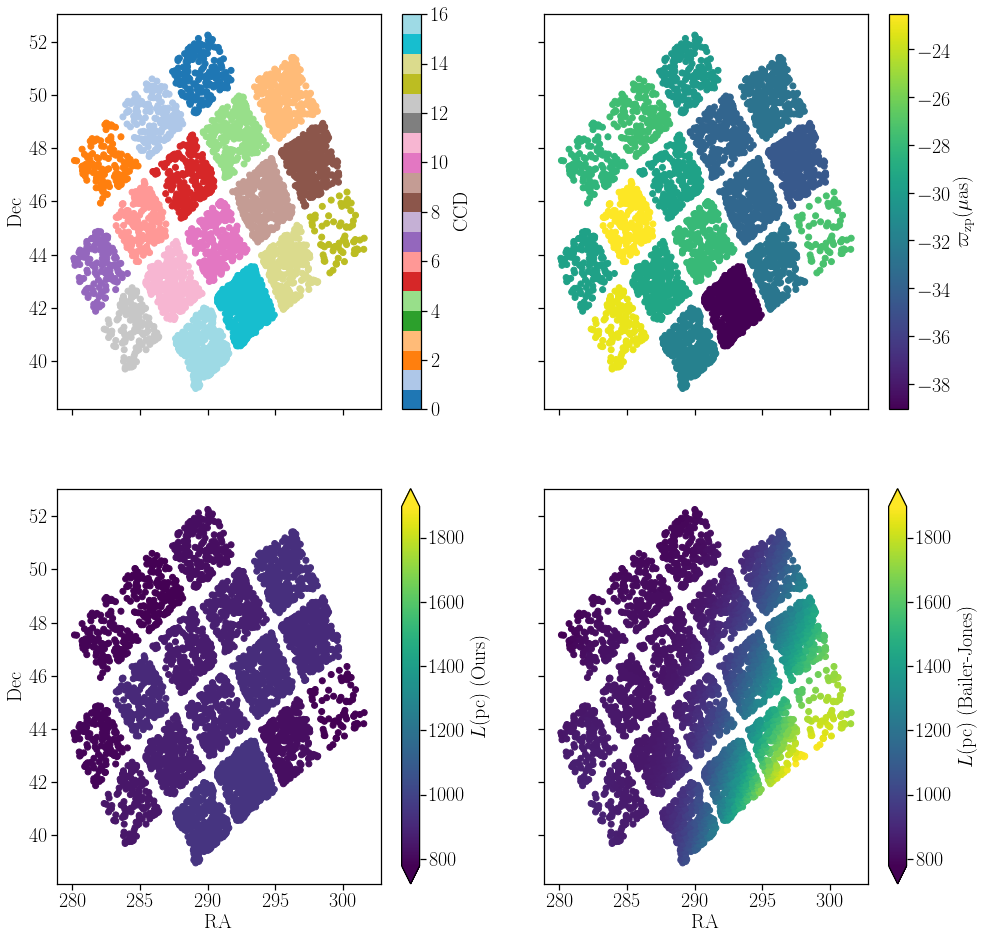

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,16),sharex=True, sharey=True)
c1 = ax1.scatter(df.ra, df.dec, c = df.ccd, cmap='tab20')
c2 = ax2.scatter(df.ra, df.dec, c = df.oo_zp, cmap='viridis')
c3 = ax3.scatter(df.ra, df.dec, c = df.L, vmin=df.r_length_prior.min(), vmax = df.r_length_prior.max())
c4 = ax4.scatter(df.ra, df.dec, c = df.r_length_prior,vmin=df.r_length_prior.min(), vmax = df.r_length_prior.max())

fig.colorbar(c1,ax=ax1,label='CCD')
fig.colorbar(c2, ax=ax2, label=r'$\varpi_{\rm zp} (\mu \rm as)$')
fig.colorbar(c3, ax=ax3, label=r'$L (\rm pc)$ (Ours)', extend='both')
fig.colorbar(c4, ax=ax4, label=r'$L (\rm pc)$ (Bailer-Jones)', extend='both')

ax3.set_xlabel('RA')
ax4.set_xlabel('RA')
ax1.set_ylabel('Dec')
ax3.set_ylabel('Dec')

plt.show()

# Conclusions

Some of this I'm not sure about. For starters there are some clear outliers, such as CCD 13. Then the gradient of L exists as expected but is not in the same direction as we expect from the Bailer-Jones work. Whats more, our own brief study of TRILEGAL simulations of the Kepler field indicate that Bailer-Jones **underestimates** the length scale L by including MS and Sub-giant stars in their sample, so really our values should be larger, now smaller.

Maybe theres still an issue with the model? It would be interesting to rerun on a ccd-by-ccd basis but without accounting for covariance.

**Another explanation** of course would be that the position of the clump varies throughout the field, and that the zero-point is adjusting for this.